In [172]:
import os
from glob import glob
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import gridspec
import seaborn as sns
import json
import torch

from bnn_priors.exp_utils import load_samples

sns.set(context="paper", style="whitegrid", font_scale=1.5)
%matplotlib inline

## Define functions

In [173]:
# Adapted from https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python

import scipy.stats as st
import warnings
import tqdm
from sklearn.mixture import GaussianMixture

# Create models from data
def best_fit_distribution(data, bins=200):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    #DISTRIBUTIONS = [st.cauchy,st.gennorm,st.laplace,st.norm,st.t]
    DISTRIBUTIONS = [st.laplace,st.norm,st.t]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf
    
    sses = {}

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:
        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))
                
                sses[distribution.name] = sse

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            f"Failed to fit {distribution}"

    return (best_distribution.name, best_params, sses)


def make_pdf(dist, params, size=1000, start=None, end=None):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    if start is None:
        start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    if end is None:
        end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

In [174]:
def plot_weightdist(weights, title=None, num_bins=50):
    fig, axes = plt.subplots(ncols=2, figsize=(8,3))
    vmin = np.min([weight for weight in weights.values()])
    vmax = np.max([weight for weight in weights.values()])
    xlim = (vmin, vmax)
    for (name, weight), ax in zip(weights.items(), axes):
        sns.distplot(weight.flatten(), ax=ax, bins=num_bins, kde=False, norm_hist=True)
        ax.set_xlabel(name)
        gauss_pdf = make_pdf(stats.norm, stats.norm.fit(weight), start=xlim[0], end=xlim[1])
        sns.lineplot(data=gauss_pdf, label="gaussian_fit", ax=ax)
        ax.legend(loc="upper right")
        ax.set_xlim(xlim)
    if title is not None:
        fig.suptitle(title)
        fig.tight_layout(rect=[0, 0, 1, 0.97])
    else:
        fig.tight_layout()
    return fig

In [175]:
def plot_covariance(weights_reshaped, rowvar, title=None):
    fig = plt.figure(figsize=(9,4))
    grid = gridspec.GridSpec(nrows=1,ncols=3,figure=fig,width_ratios=[20,20,1])
    axes = [plt.subplot(spec) for spec in grid]
    vmin = np.min([np.cov(weight, rowvar=rowvar) for weight in weights_reshaped.values()])
    vmax = np.max([np.cov(weight, rowvar=rowvar) for weight in weights_reshaped.values()])
    for (name, weight), ax in zip(weights_reshaped.items(), axes):
        sns.heatmap(np.cov(weight, rowvar=rowvar), cmap="Blues", ax=ax, vmin=vmin, vmax=vmax, cbar=(name=="empirical"), cbar_ax=axes[2])
        ax.set_xlabel(name)
    if title is not None:
        fig.suptitle(title)
        fig.tight_layout(rect=[0, 0, 1, 0.97])
    else:
        fig.tight_layout()
    return fig

In [176]:
def plot_covar_offdiagonals(weights_reshaped, rowvar, title=None, num_bins=50):
    fig, axes = plt.subplots(ncols=2, figsize=(8,3))
    vmin = np.min([np.cov(weight, rowvar=rowvar) for weight in weights_reshaped.values()])
    xlim = (vmin,-vmin)
    for (name, weight), ax in zip(weights_reshaped.items(), axes):
        covar = np.cov(weight, rowvar=rowvar)
        offdiagonals = covar[np.where(~np.eye(covar.shape[0],dtype=bool))]
        sns.distplot(offdiagonals, ax=ax, bins=num_bins, kde=False, norm_hist=True)
        ax.set_xlabel(name)
        ax.set_xlim(xlim)
        gauss_pdf = make_pdf(stats.norm, stats.norm.fit(offdiagonals), start=xlim[0], end=xlim[1])
        sns.lineplot(data=gauss_pdf, label="gaussian_fit", ax=ax)
        ax.legend(loc="upper right")
    if title is not None:
        fig.suptitle(title)
        fig.tight_layout(rect=[0, 0, 1, 0.97])
    else:
        fig.tight_layout()
    return fig

In [177]:
def plot_covar_offdiagonals_reduced(weights_reshaped, rowvar, title=None, num_bins=50):
    fig, ax = plt.subplots(figsize=(4,3))
    vmin = np.min([np.cov(weight, rowvar=rowvar) for weight in weights_reshaped.values()])
    xlim = (vmin,-vmin)
    for name in ["empirical", "gaussian"]:
        weight = weights_reshaped[name]
        covar = np.cov(weight, rowvar=rowvar)
        offdiagonals = covar[np.where(~np.eye(covar.shape[0],dtype=bool))]
        if name == "empirical":
            sns.distplot(offdiagonals, ax=ax, bins=num_bins, kde=False, norm_hist=True)
            ax.set_xlabel(name)
            ax.set_xlim(xlim)
        else:
            gauss_pdf = make_pdf(stats.norm, stats.norm.fit(offdiagonals), start=xlim[0], end=xlim[1])
            sns.lineplot(data=gauss_pdf, label="gaussian_weights", ax=ax)
            ax.legend(loc="upper right")
        ax.tick_params(left=False, labelleft=False)

    if title is not None:
        fig.suptitle(title)
        fig.tight_layout(rect=[0, 0, 1, 0.97])
    else:
        fig.tight_layout()
    return fig

In [178]:
def plot_singular_values(weights_reshaped, title=None, num_bins=10):
    fig, axes = plt.subplots(ncols=2, figsize=(8,3))
    for (name, weight), ax in zip(weights_reshaped.items(), axes):
        _, singvals, _ = np.linalg.svd(weight)
        sns.distplot(singvals, ax=ax, bins=num_bins, kde=False, norm_hist=True)
        ax.set_xlabel(name)
    if title is not None:
        fig.suptitle(title)
        fig.tight_layout(rect=[0, 0, 1, 0.97])
    else:
        fig.tight_layout()
    return fig

In [179]:
def generate_all_figures(state_dict, exp_name, cnn=True):
    if cnn:
        num_channels = 4
    else:
        num_channels = 2
    with PdfPages(f"../figures/{exp_name}_weight_distributions.pdf") as pdf:
        for param, weight_values in state_dict.items():
            if "weight_prior.p" in param and len(weight_values.shape) == num_channels:
                layer = param.split("weight_prior.p")[0]
                print(layer)

                weight = weight_values.numpy()
                weight_gaussian = np.random.normal(loc=weight.mean(), scale=weight.std(), size=weight.shape)
                weights = {"gaussian": weight_gaussian, "empirical": weight}
                weights_reshaped = {name : weight.reshape(weight.shape[0], -1) for name, weight in weights.items()}

                fig = plot_weightdist(weights, title=f"{layer}weight_distribution")
                pdf.savefig()
                plt.close(fig)
                fig = plot_covariance(weights_reshaped, False, title=f"{layer}covariance_inputs")
                pdf.savefig()
                plt.close(fig)
                fig = plot_covariance(weights_reshaped, True, title=f"{layer}covariance_outputs")
                pdf.savefig()
                plt.close(fig)
                fig = plot_covar_offdiagonals(weights_reshaped, False, title=f"{layer}covar_offdiag_inputs")
                pdf.savefig()
                plt.close(fig)
                fig = plot_covar_offdiagonals(weights_reshaped, True, title=f"{layer}covar_offdiag_outputs")
                pdf.savefig()
                plt.close(fig)
                fig = plot_singular_values(weights_reshaped, title=f"{layer}singular_values")
                pdf.savefig()
                plt.close(fig)
    print("done!")

## Generate plots for paper

In [180]:
import h5py
import collections


def load_many_samples(path, directories=range(8)):
    param_keys = None
    samples = collections.defaultdict(lambda: [], {})

    for d in map(str, directories):
        with h5py.File(path + f"/{d}/samples.pt", "r") as f:
            if param_keys is None:
                param_keys = [k for k in f.keys() if k.endswith(".p")]

            for key in param_keys:
                samples[key].append(f[key][-1])
    for k in samples.keys():
        samples[k] = np.stack(samples[k])
    return samples

def reshape_weight(weight, f):
    weight = f(weight)
    weight_gaussian = np.random.normal(loc=weight.mean(), scale=weight.std(), size=weight.shape)
    return {"gaussian": weight_gaussian, "empirical": weight}

#### MNIST CNN

In [181]:
exp_name = "mnist_classificationconvnet"

In [182]:
samples = load_many_samples(f"../logs/sgd-no-weight-decay/{exp_name}/")

exp_name = "201110_"+exp_name

/scratches/huygens/ag919/venv/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/scratches/huygens/ag919/venv/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


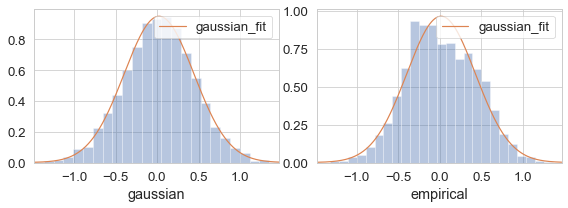

In [183]:
key = "net.module.1.weight_prior.p"

fig = plot_weightdist(reshape_weight(samples[key], lambda x: x), num_bins=25)

In [184]:
def reshape_input_covar(weights):
    return reshape_weight(weights, lambda w: w.transpose((0, 1, 2, 3, 4)).reshape((w.shape[0]*w.shape[1], -1)))
def reshape_output_covar(weights):
    return reshape_weight(weights, lambda w: w.transpose((0, 2, 3, 4, 1)).reshape((-1, w.shape[1])))

In [185]:
fig.savefig(f"../figures/{exp_name}_layer1_weightdist.pdf")

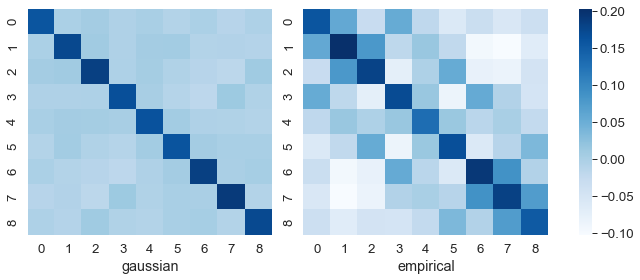

In [186]:
fig = plot_covariance(reshape_input_covar(samples[key]),  rowvar=False)

In [187]:
fig.savefig(f"../figures/{exp_name}_layer1_covar_inputs.pdf")

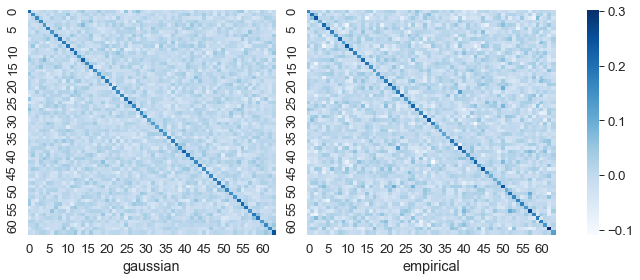

In [188]:
fig = plot_covariance(reshape_output_covar(samples[key]),  rowvar=False)

In [189]:
fig.savefig(f"../figures/{exp_name}_layer1_covar_outputs.pdf")

/scratches/huygens/ag919/venv/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/scratches/huygens/ag919/venv/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


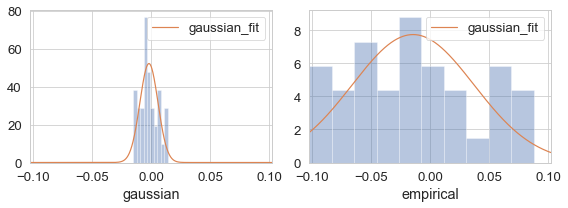

In [190]:
fig = plot_covar_offdiagonals(reshape_input_covar(samples[key]), rowvar=False, num_bins=10)

In [191]:
fig.savefig(f"../figures/{exp_name}_layer1_offdiag_input.pdf")

/scratches/huygens/ag919/venv/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/scratches/huygens/ag919/venv/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


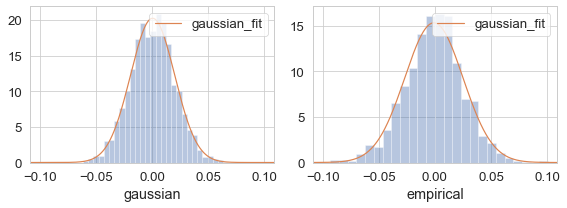

In [192]:
fig = plot_covar_offdiagonals(reshape_output_covar(samples[key]), rowvar=False, num_bins=30)

In [193]:
fig.savefig(f"../figures/{exp_name}_layer1_offdiag_output.pdf")

/scratches/huygens/ag919/venv/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


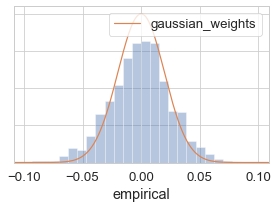

In [194]:
fig = plot_covar_offdiagonals_reduced(reshape_output_covar(samples[key]), rowvar=False, num_bins=30)

In [195]:
fig.savefig(f"../figures/{exp_name}_layer1_offdiag_output_reduced.pdf")

/scratches/huygens/ag919/venv/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


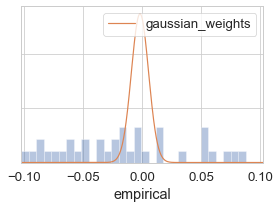

In [196]:
fig = plot_covar_offdiagonals_reduced(reshape_input_covar(samples[key]), rowvar=False, num_bins=30)

In [197]:
fig.savefig(f"../figures/{exp_name}_layer1_offdiag_input_reduced.pdf")

/scratches/huygens/ag919/venv/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


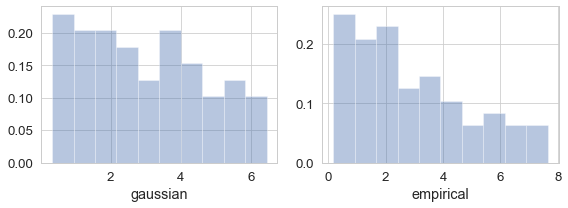

In [198]:
fig = plot_singular_values(reshape_output_covar(samples[key]), num_bins=10)

In [199]:
fig.savefig(f"../figures/{exp_name}_layer1_singvals.pdf")

In [200]:
key = "net.module.4.weight_prior.p"

/scratches/huygens/ag919/venv/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/scratches/huygens/ag919/venv/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


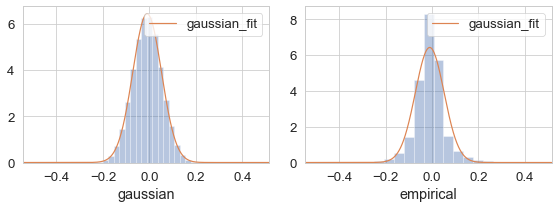

In [201]:

fig = plot_weightdist(reshape_weight(samples[key], lambda x: x), num_bins=25)

In [202]:
fig.savefig(f"../figures/{exp_name}_layer2_weightdist.pdf")

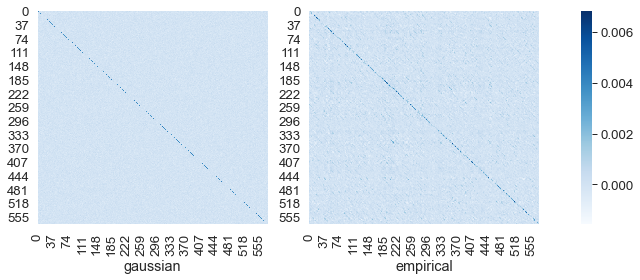

In [203]:
fig = plot_covariance(reshape_input_covar(samples[key]),  rowvar=False)

In [204]:
fig.savefig(f"../figures/{exp_name}_layer2_covar_inputs.pdf")

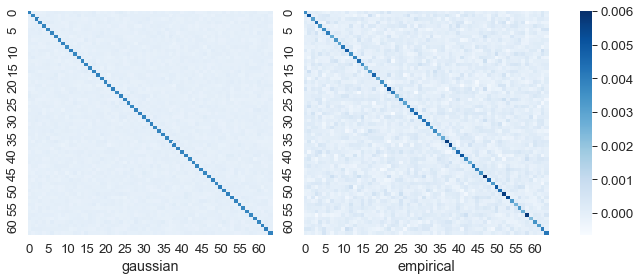

In [205]:
fig = plot_covariance(reshape_output_covar(samples[key]),  rowvar=False)

In [206]:
fig.savefig(f"../figures/{exp_name}_layer2_covar_outputs.pdf")

/scratches/huygens/ag919/venv/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/scratches/huygens/ag919/venv/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


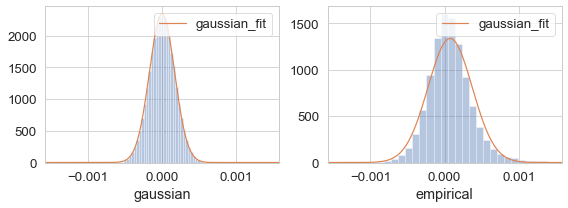

In [207]:
fig = plot_covar_offdiagonals(reshape_input_covar(samples[key]), rowvar=False, num_bins=50)

In [208]:
fig.savefig(f"../figures/{exp_name}_layer2_offdiag_input.pdf")

/scratches/huygens/ag919/venv/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/scratches/huygens/ag919/venv/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


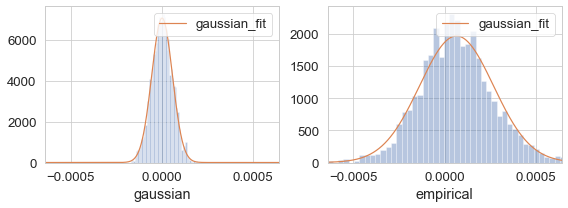

In [209]:
fig = plot_covar_offdiagonals(reshape_output_covar(samples[key]), rowvar=False, num_bins=50)

In [210]:
fig.savefig(f"../figures/{exp_name}_layer2_offdiag_output.pdf")

/scratches/huygens/ag919/venv/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


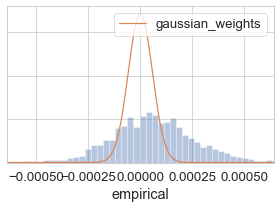

In [211]:
fig = plot_covar_offdiagonals_reduced(reshape_output_covar(samples[key]), rowvar=False, num_bins=50)

In [212]:
fig.savefig(f"../figures/{exp_name}_layer2_offdiag_output_reduced.pdf")

/scratches/huygens/ag919/venv/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


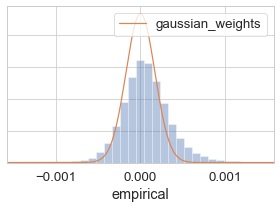

In [213]:
fig = plot_covar_offdiagonals_reduced(reshape_input_covar(samples[key]), rowvar=False, num_bins=50)

In [214]:
fig.savefig(f"../figures/{exp_name}_layer2_offdiag_input_reduced.pdf")

/scratches/huygens/ag919/venv/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


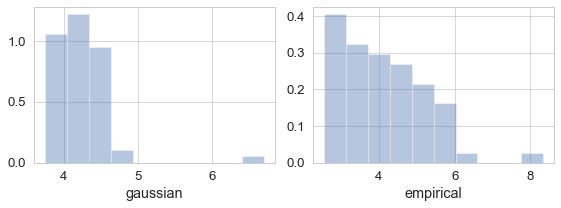

In [215]:
fig = plot_singular_values(reshape_output_covar(samples[key]), num_bins=10)

In [216]:
fig.savefig(f"../figures/{exp_name}_layer2_singvals.pdf")

In [217]:
samples [key].shape

(8, 64, 64, 3, 3)

In [218]:
weights_reshaped = {name : weight.reshape(-1, 9) for name, weight in reshape_weight(samples[key], lambda w: w).items()}

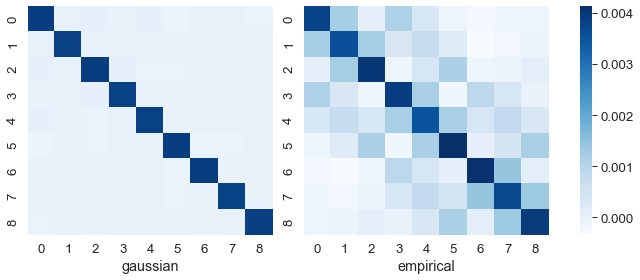

In [219]:
fig = plot_covariance(weights_reshaped, rowvar=False)

In [220]:
fig.savefig(f"../figures/{exp_name}_layer2_covar_channels.pdf")

/scratches/huygens/ag919/venv/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


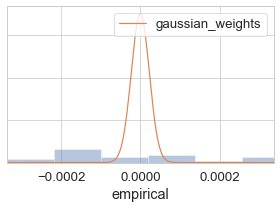

In [221]:
fig = plot_covar_offdiagonals_reduced(weights_reshaped, rowvar=False, num_bins=15)
fig.savefig(f"../figures/{exp_name}_layer2_offdiag_spatial_reduced.pdf")

#### MNIST feedforward

In [222]:
exp_name = "mnist_classificationdensenet"

In [223]:
samples = load_many_samples(f"../logs/sgd-no-weight-decay/{exp_name}/", filter(lambda x: x != 5, range(10)))

exp_name = "201110_"+exp_name

/scratches/huygens/ag919/venv/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/scratches/huygens/ag919/venv/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


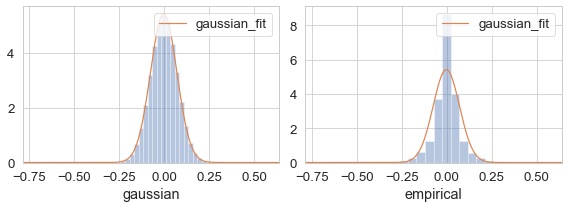

In [224]:
key = "net.module.0.weight_prior.p"

fig = plot_weightdist(reshape_weight(samples[key], lambda x: x), num_bins=30)

In [225]:
def reshape_input_covar(weights):
    return reshape_weight(weights, lambda w: w.transpose((0, 1, 2)).reshape((w.shape[0]*w.shape[1], -1)))
def reshape_output_covar(weights):
    return reshape_weight(weights, lambda w: w.transpose((0, 2, 1)).reshape((-1, w.shape[1])))

In [226]:
fig.savefig(f"../figures/{exp_name}_layer1_weightdist.pdf")

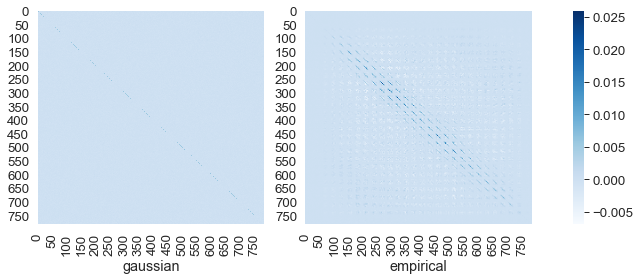

In [227]:
fig = plot_covariance(reshape_input_covar(samples[key]),  rowvar=False)

In [228]:
fig.savefig(f"../figures/{exp_name}_layer1_covar_inputs.pdf")

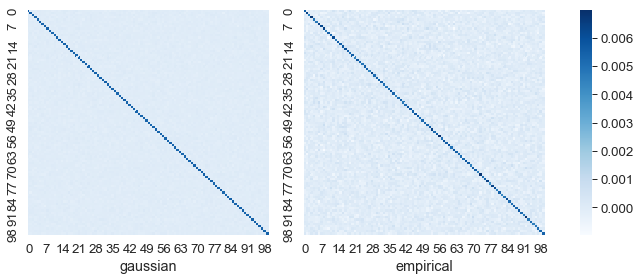

In [229]:
fig = plot_covariance(reshape_output_covar(samples[key]),  rowvar=False)

In [230]:
fig.savefig(f"../figures/{exp_name}_layer1_covar_outputs.pdf")

/scratches/huygens/ag919/venv/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/scratches/huygens/ag919/venv/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


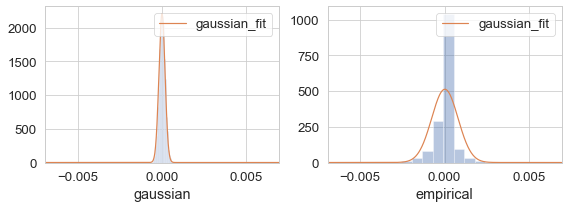

In [231]:
fig = plot_covar_offdiagonals(reshape_input_covar(samples[key]), rowvar=False, num_bins=40)

In [232]:
fig.savefig(f"../figures/{exp_name}_layer1_offdiag_input.pdf")

/scratches/huygens/ag919/venv/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/scratches/huygens/ag919/venv/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


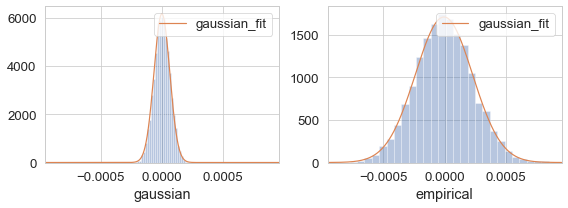

In [233]:
fig = plot_covar_offdiagonals(reshape_output_covar(samples[key]), rowvar=False, num_bins=30)

In [234]:
fig.savefig(f"../figures/{exp_name}_layer1_offdiag_output.pdf")

/scratches/huygens/ag919/venv/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


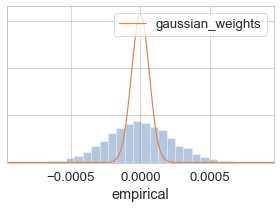

In [235]:
fig = plot_covar_offdiagonals_reduced(reshape_output_covar(samples[key]), rowvar=False, num_bins=30)

In [236]:
fig.savefig(f"../figures/{exp_name}_layer1_offdiag_output_reduced.pdf")

/scratches/huygens/ag919/venv/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


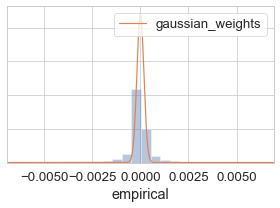

In [237]:
fig = plot_covar_offdiagonals_reduced(reshape_input_covar(samples[key]), rowvar=False, num_bins=50)

In [238]:
fig.savefig(f"../figures/{exp_name}_layer1_offdiag_input_reduced.pdf")

/scratches/huygens/ag919/venv/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


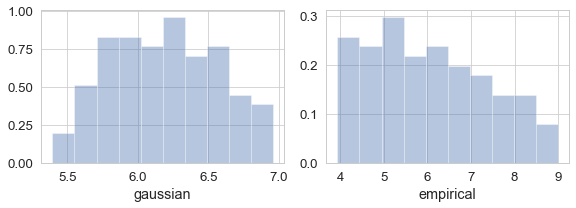

In [239]:
fig = plot_singular_values(reshape_output_covar(samples[key]), num_bins=10)

In [240]:
fig.savefig(f"../figures/{exp_name}_layer1_singvals.pdf")

In [241]:
key = "net.module.2.weight_prior.p"

/scratches/huygens/ag919/venv/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/scratches/huygens/ag919/venv/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


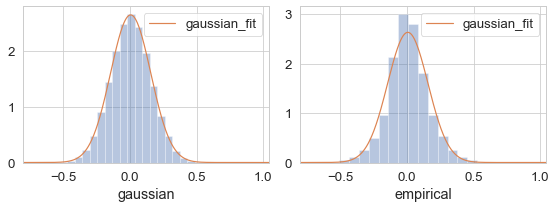

In [242]:

fig = plot_weightdist(reshape_weight(samples[key], lambda x: x), num_bins=25)

In [243]:
fig.savefig(f"../figures/{exp_name}_layer2_weightdist.pdf")

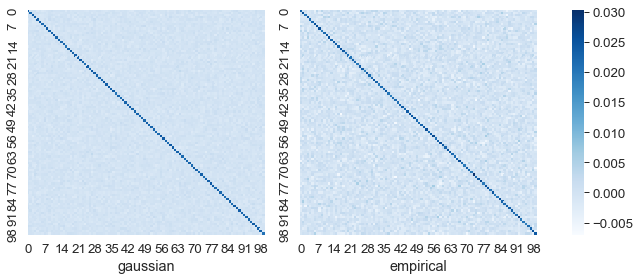

In [244]:
fig = plot_covariance(reshape_input_covar(samples[key]),  rowvar=False)

In [245]:
fig.savefig(f"../figures/{exp_name}_layer2_covar_inputs.pdf")

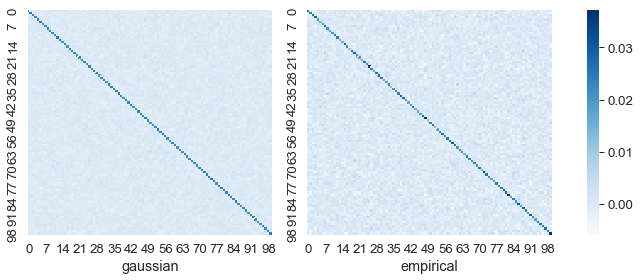

In [246]:
fig = plot_covariance(reshape_output_covar(samples[key]),  rowvar=False)

In [247]:
fig.savefig(f"../figures/{exp_name}_layer2_covar_outputs.pdf")

/scratches/huygens/ag919/venv/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/scratches/huygens/ag919/venv/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


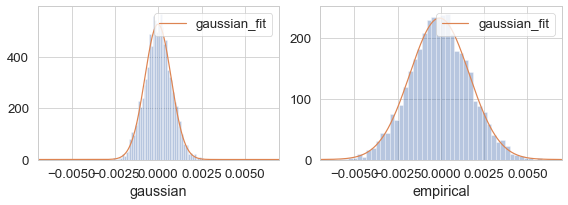

In [248]:
fig = plot_covar_offdiagonals(reshape_input_covar(samples[key]), rowvar=False, num_bins=50)

In [249]:
fig.savefig(f"../figures/{exp_name}_layer2_offdiag_input.pdf")

/scratches/huygens/ag919/venv/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/scratches/huygens/ag919/venv/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


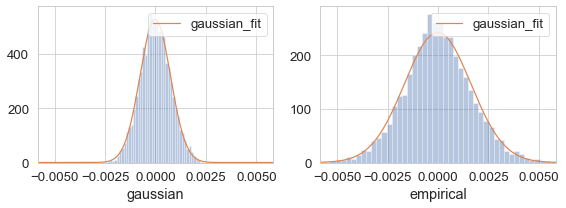

In [250]:
fig = plot_covar_offdiagonals(reshape_output_covar(samples[key]), rowvar=False, num_bins=50)

In [251]:
fig.savefig(f"../figures/{exp_name}_layer2_offdiag_output.pdf")

/scratches/huygens/ag919/venv/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


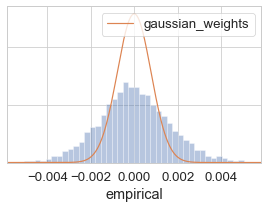

In [252]:
fig = plot_covar_offdiagonals_reduced(reshape_output_covar(samples[key]), rowvar=False, num_bins=50)

In [253]:
fig.savefig(f"../figures/{exp_name}_layer2_offdiag_output_reduced.pdf")

/scratches/huygens/ag919/venv/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


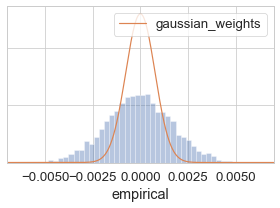

In [254]:
fig = plot_covar_offdiagonals_reduced(reshape_input_covar(samples[key]), rowvar=False, num_bins=50)

In [255]:
fig.savefig(f"../figures/{exp_name}_layer2_offdiag_input_reduced.pdf")

/scratches/huygens/ag919/venv/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


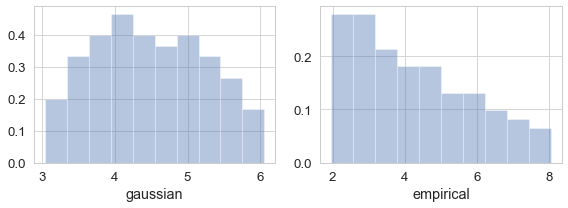

In [256]:
fig = plot_singular_values(reshape_output_covar(samples[key]), num_bins=10)

In [257]:
fig.savefig(f"../figures/{exp_name}_layer2_singvals.pdf")

In [258]:
weights_reshaped = {name : weight.reshape(-1, 9) for name, weight in reshape_weight(samples[key], lambda w: w).items()}

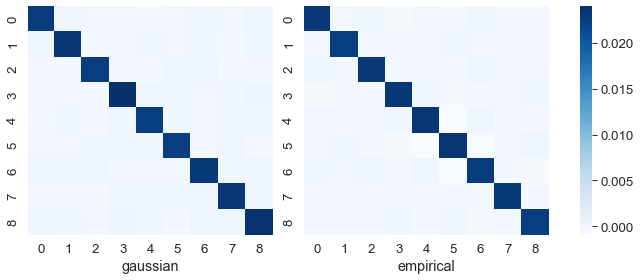

In [259]:
fig = plot_covariance(weights_reshaped, rowvar=False)

In [260]:
fig.savefig(f"../figures/{exp_name}_layer2_covar_channels.pdf")

In [261]:
key = "net.module.4.weight_prior.p"

/scratches/huygens/ag919/venv/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/scratches/huygens/ag919/venv/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


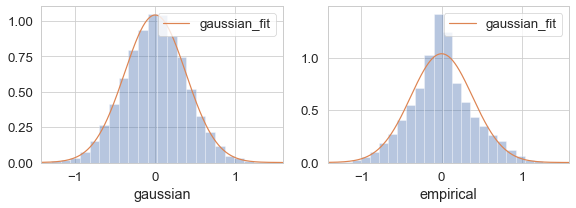

In [262]:

fig = plot_weightdist(reshape_weight(samples[key], lambda x: x), num_bins=25)

In [263]:
fig.savefig(f"../figures/{exp_name}_layer3_weightdist.pdf")

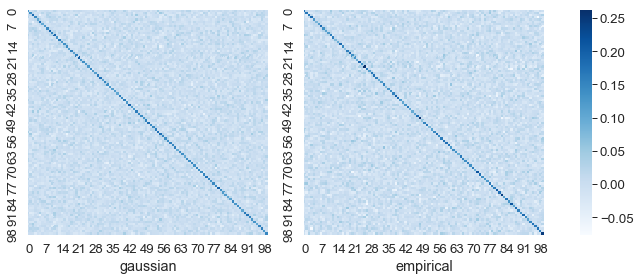

In [264]:
fig = plot_covariance(reshape_input_covar(samples[key]),  rowvar=False)

In [265]:
fig.savefig(f"../figures/{exp_name}_layer3_covar_inputs.pdf")

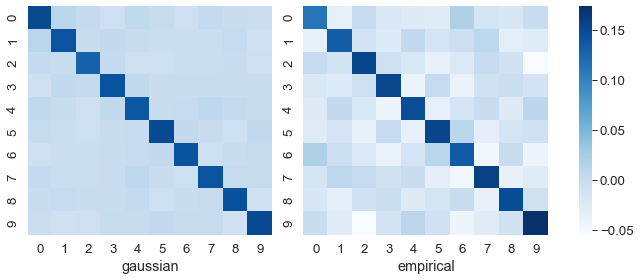

In [266]:
fig = plot_covariance(reshape_output_covar(samples[key]),  rowvar=False)

In [267]:
fig.savefig(f"../figures/{exp_name}_layer3_covar_outputs.pdf")

/scratches/huygens/ag919/venv/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/scratches/huygens/ag919/venv/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


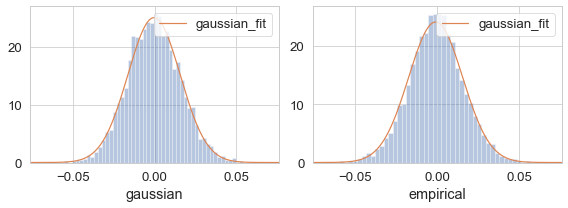

In [268]:
fig = plot_covar_offdiagonals(reshape_input_covar(samples[key]), rowvar=False, num_bins=50)

In [269]:
fig.savefig(f"../figures/{exp_name}_layer3_offdiag_input.pdf")

/scratches/huygens/ag919/venv/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/scratches/huygens/ag919/venv/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


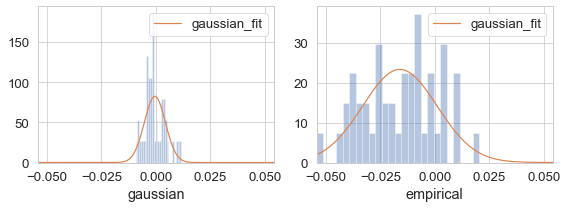

In [270]:
fig = plot_covar_offdiagonals(reshape_output_covar(samples[key]), rowvar=False, num_bins=25)

In [271]:
fig.savefig(f"../figures/{exp_name}_layer3_offdiag_output.pdf")

/scratches/huygens/ag919/venv/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


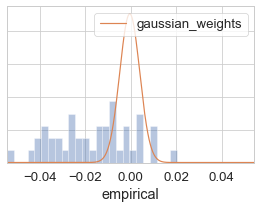

In [272]:
fig = plot_covar_offdiagonals_reduced(reshape_output_covar(samples[key]), rowvar=False, num_bins=25)

In [273]:
fig.savefig(f"../figures/{exp_name}_layer3_offdiag_output_reduced.pdf")

/scratches/huygens/ag919/venv/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


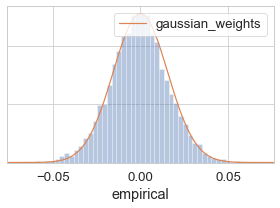

In [274]:
fig = plot_covar_offdiagonals_reduced(reshape_input_covar(samples[key]), rowvar=False, num_bins=50)

In [275]:
fig.savefig(f"../figures/{exp_name}_layer3_offdiag_input_reduced.pdf")

/scratches/huygens/ag919/venv/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


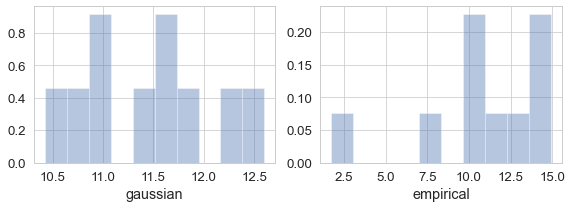

In [276]:
fig = plot_singular_values(reshape_output_covar(samples[key]), num_bins=10)

In [277]:
fig.savefig(f"../figures/{exp_name}_layer3_singvals.pdf")

#### Compare weight dists side-by-side

In [278]:
#samples_file = f"../results/200922_mnist_cnn/16/samples.pt"

key = 'net.module.4.weight_prior.p'

w_list = []
for i in range(8):
    samples_file = f"../logs/sgd-no-weight-decay/mnist_classificationconvnet/{i}/samples.pt"
    s = load_samples(samples_file)
    w_list.append(s[key][-1].numpy())
weight_cnn = np.stack(w_list)

In [279]:
#samples_file = f"../results/200917_mnist/18/samples.pt"

key = 'net.module.0.weight_prior.p'


w_list = []
for i in range(10):
    if i ==5 :
        continue
    samples_file = f"../logs/sgd-no-weight-decay/mnist_classificationdensenet/{i}/samples.pt"
    s = load_samples(samples_file)
    w_list.append(s[key][-1].numpy())
weight_dnn = np.stack(w_list)

In [280]:
def empirical_cdf(w):
    sorted_w = np.sort(w.flatten())

    x = np.stack([sorted_w]*2, axis=1).flatten()
    y = np.stack([np.arange(0, len(sorted_w)), np.arange(1, len(sorted_w)+1)], axis=1).flatten() / len(sorted_w)
    return sorted_w, x, y

def qqplot(ax, w, stats_dist, **kwargs):
    sparams = stats_dist.fit(w.flatten())
    xs, ys = stats.probplot(w, sparams, dist=stats_dist, fit=False, plot=None)
    ax.plot(xs, ys, **kwargs)
    

def empirical_fd_pdf(ax, w, smooth=3000):
    sorted_w = np.sort(w.flatten())
    y = np.arange(1, len(sorted_w)+1)
    
    x_defined = sorted_w[smooth:-smooth]
    fd_raw = y[smooth*2:] - y[:-smooth*2]
    x_fd = sorted_w[smooth*2:] - sorted_w[:-smooth*2]
    fd = (fd_raw/x_fd) / len(sorted_w)
    ax.plot(x_defined, np.clip(fd, 0., 200.))
    return sorted_w

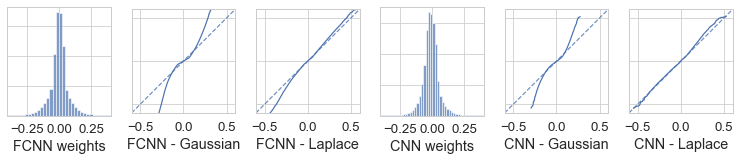

In [281]:
fig, axes = plt.subplots(ncols=6, figsize=(13,2), sharex=False)
xlim = (-0.4, 0.4)

ax = axes[0]
ax.hist(weight_dnn.ravel(), bins=60, density=True, alpha=0.7)
ax.set_xlabel("FCNN weights")
ax.set_xlim((-0.4, 0.4))
ax.tick_params(left=False, labelleft=False)

ax = axes[1]
lim = 0.6
qqplot(ax, weight_dnn.ravel(), stats.norm)
ax.set_xlim((-lim, lim))
ax.set_ylim((-lim, lim))
ax.plot([-lim, lim], [-lim, lim], linestyle="--", alpha=0.8, color="C0")
ax.set_xlabel("FCNN - Gaussian")
ax.set_aspect('equal')
ax.tick_params(left=False, labelleft=False)


ax = axes[2]
qqplot(ax, weight_dnn.ravel(), stats.laplace)
ax.set_xlim((-lim, lim))
ax.set_ylim((-lim, lim))
ax.plot([-lim, lim], [-lim, lim], linestyle="--", alpha=0.8, color="C0")
ax.set_xlabel("FCNN - Laplace")
ax.set_aspect('equal')
ax.tick_params(left=False, labelleft=False)


ax = axes[3]
ax.hist(weight_cnn.flatten(), bins=60, density=True, alpha=0.7)
ax.set_xlabel("CNN weights")
ax.set_xlim((-0.4, 0.4))
ax.tick_params(left=False, labelleft=False)



ax = axes[4]
qqplot(ax, weight_cnn.flatten(), stats.norm)
ax.set_xlim((-lim, lim))
ax.set_ylim((-lim, lim))
ax.plot([-lim, lim], [-lim, lim], linestyle="--", alpha=0.8, color="C0")
ax.set_xlabel("CNN - Gaussian")
ax.set_aspect('equal')
ax.tick_params(left=False, labelleft=False)


ax = axes[5]
qqplot(ax, weight_cnn.flatten(), stats.laplace)
ax.set_xlim((-lim, lim))
ax.set_ylim((-lim, lim))
ax.plot([-lim, lim], [-lim, lim], linestyle="--", alpha=0.8, color="C0")
ax.set_xlabel("CNN - Laplace")
ax.set_aspect('equal')
ax.tick_params(left=False, labelleft=False)

plt.savefig("../figures/201110_qqplots.pdf", bbox_inches='tight')

In [282]:
np.sum(np.sort(np.abs(weight_cnn.flatten())) < 1e-8)

0

In [283]:
len(weight_cnn.flatten())

294912

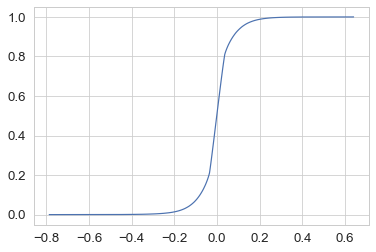

In [284]:
_, xs, ys = empirical_cdf(weight_dnn)
plt.plot(xs, ys)
#plt.xlim((-0.01, 0.01))

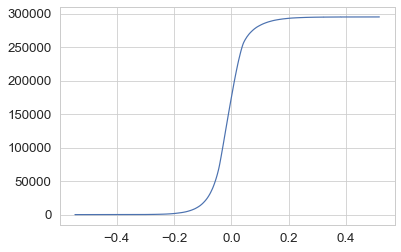

In [285]:
w = np.copy(weight_cnn.flatten())
sorted_w = np.sort(w)

x = np.stack([sorted_w]*2, axis=1).flatten()
y = np.stack([np.arange(0, len(w)), np.arange(1, len(w)+1)], axis=1).flatten()

plt.plot(x, y)

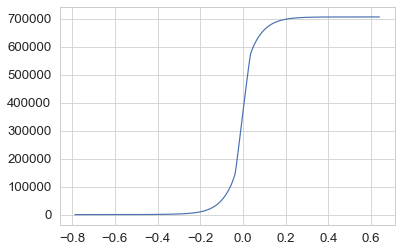

In [286]:
w = np.copy(weight_dnn.flatten())
sorted_w = np.sort(w)

x = np.stack([sorted_w]*2, axis=1).flatten()
y = np.stack([np.arange(0, len(w)), np.arange(1, len(w)+1)], axis=1).flatten()

plt.plot(x, y)

In [287]:
np.arange(0, 0.1, 0.005)

array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
       0.045, 0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085,
       0.09 , 0.095])

In [288]:
fig.savefig(f"../figures/200917_mnist_vs_200922_mnist_cnn_weight_dists.pdf", bbox_inches = 'tight', pad_inches = 0.1)

In [289]:
weights = {"dnn": weight_dnn.flatten(), "cnn": weight_cnn.flatten()}
for param, weight in weights.items():
    print(f"Normality tests for {param}:")
    print(f"Mean = {weight.mean():.2f}, std = {weight.flatten().std():.2f}")
    print("D'Angostino: statistic = {0:.2f}, p-value = {1:.2e}".format(*stats.normaltest(weight)))
    print("Shapiro: statistic = {0:.2f}, p-value = {1:.2e}".format(*stats.shapiro(np.random.choice(weight, size=min(5000, len(weight)), replace=False))))

Normality tests for dnn:
Mean = -0.00, std = 0.07
D'Angostino: statistic = 91419.38, p-value = 0.00e+00
Shapiro: statistic = 0.92, p-value = 0.00e+00
Normality tests for cnn:
Mean = -0.01, std = 0.06
D'Angostino: statistic = 34262.71, p-value = 0.00e+00
Shapiro: statistic = 0.94, p-value = 4.24e-40
